In [ ]:
import torch
import sys

sys.path.append("../")

from samples.models import get_model, MODEL_REGISTRY

# Check available models
print(f"Available models: {list(MODEL_REGISTRY.keys())}")

# Load AFib classification model (automatically downloads if download=True and file not found)
model = get_model(
    name="afib_binary",
    model_dir="../tmp/models/afib_binary/",
    download=True,
)
print(f"Model loaded: {model.__class__.__name__}")

In [2]:
# Wrap model with TorchModelWrapper
from execg.models.wrapper import TorchModelWrapper

wrapped_model = TorchModelWrapper(model)
print(f"Wrapped model: {wrapped_model}")
print(f"Device: {wrapped_model.device}")
print(
    f"Available layers: {wrapped_model.get_layer_names()[:10]}..."
)  # Print first 10 layers

Wrapped model: TorchModelWrapper(model=ResNetDropoutAfib, device=cpu)
Device: cpu
Available layers: ['', 'conv1', 'bn1', 'relu', 'maxpool', 'stem', 'blk1d', 'blk1d.0', 'blk1d.0.0', 'blk1d.0.0.conv1']...


In [3]:
# Load or generate sample ECG data
import json
import numpy as np

# Try to load sample data
try:
    with open("../samples/data/sample.json", "r") as f:
        sample_data = json.load(f)
    ecg_signal = np.array(
        list(sample_data["data"].values())
    )  # shape: (n_leads, seq_length)
    print(f"Loaded sample ECG data: shape = {ecg_signal.shape}")
except:
    # Generate synthetic data if sample data not available
    n_leads = 12
    seq_length = 2500  # 10 seconds @ 250Hz
    ecg_signal = np.random.randn(n_leads, seq_length).astype(np.float32)
    print(f"Generated synthetic ECG data: shape = {ecg_signal.shape}")

# Convert to Tensor - transform to (1, n_leads, seq_length) shape
ecg_tensor = torch.tensor(ecg_signal, dtype=torch.float32)[:, ::2].unsqueeze(0)
print(f"ECG tensor shape: {ecg_tensor.shape}  # (batch=1, leads, length)")

Loaded sample ECG data: shape = (12, 5000)
ECG tensor shape: torch.Size([1, 12, 2500])  # (batch=1, leads, length)


## 1. SaliencyMap Attribution

Saliency Map computes the gradient of the output with respect to the input to visualize important regions for model predictions.

Supported methods:
- `vanilla_saliency`: Basic gradient
- `smooth_grad`: Average gradient with noisy inputs
- `integrated_gradients`: Path integral from baseline to input

In [ ]:
# Import visualizer module
from execg.visualizer.attribution import (
    plot_attribution,
    plot_attribution_comparison,
    bin_and_normalize,
)

In [ ]:
# Visualization settings
lead_idx = 1
bin_size = 25

Vanilla Saliency - results shape: (1, 12, 2500)


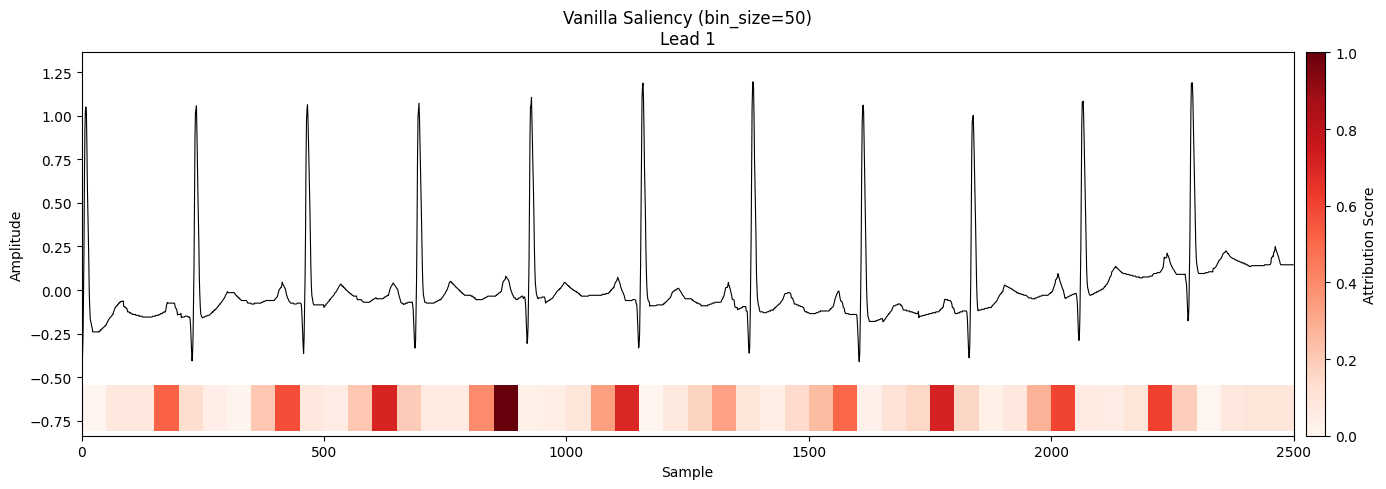

In [6]:
from execg.attribution import SaliencyMap

# Create SaliencyMap instance
saliency = SaliencyMap(
    model=wrapped_model,
    absolute=True,  # Use absolute gradient values
    normalize=True,  # Normalize to 0-1 range
)

# 1-1. Vanilla Saliency
vanilla_result = saliency.explain(ecg_tensor, method="vanilla_saliency")
print(f"Vanilla Saliency - results shape: {vanilla_result['results'].shape}")

# Vanilla Saliency visualization
plot_attribution(
    vanilla_result["inputs"][0],
    vanilla_result["results"][0],
    "Vanilla Saliency",
    lead_idx=lead_idx,
    bin_size=bin_size,
    cmap="Reds",
)

SmoothGrad - results shape: (1, 12, 2500)


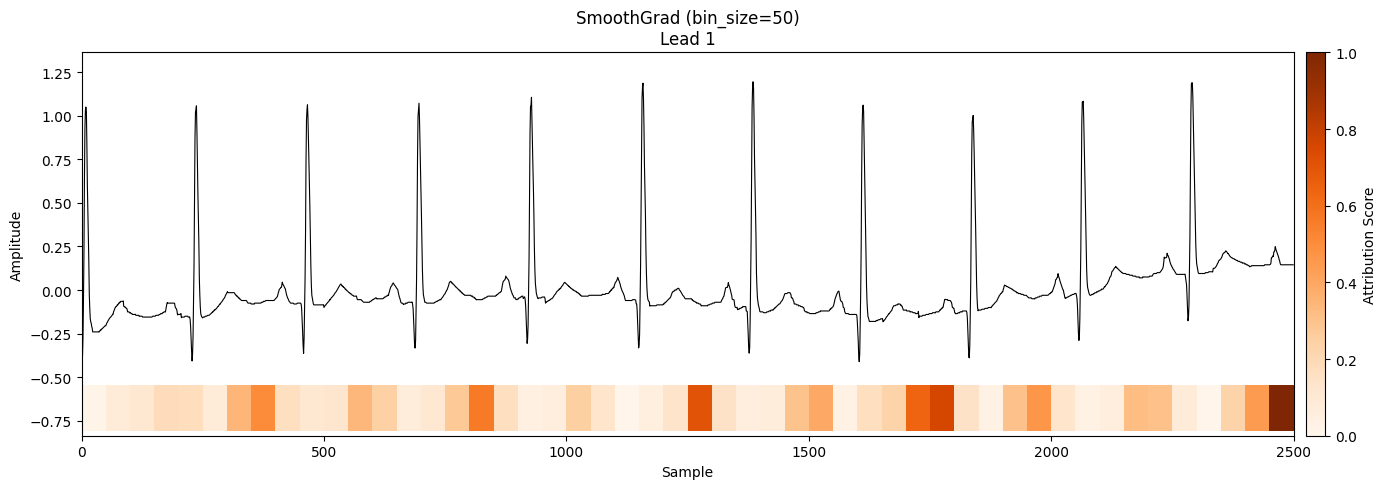

In [7]:
# 1-2. SmoothGrad
smoothgrad_result = saliency.explain(
    ecg_tensor,
    method="smooth_grad",
    n_samples=30,  # Number of noise samples
    noise_level=0.1,  # Noise level
)
print(f"SmoothGrad - results shape: {smoothgrad_result['results'].shape}")

# SmoothGrad visualization
plot_attribution(
    smoothgrad_result["inputs"][0],
    smoothgrad_result["results"][0],
    "SmoothGrad",
    lead_idx=lead_idx,
    bin_size=bin_size,
    cmap="Oranges",
)

Integrated Gradients - results shape: (1, 12, 2500)


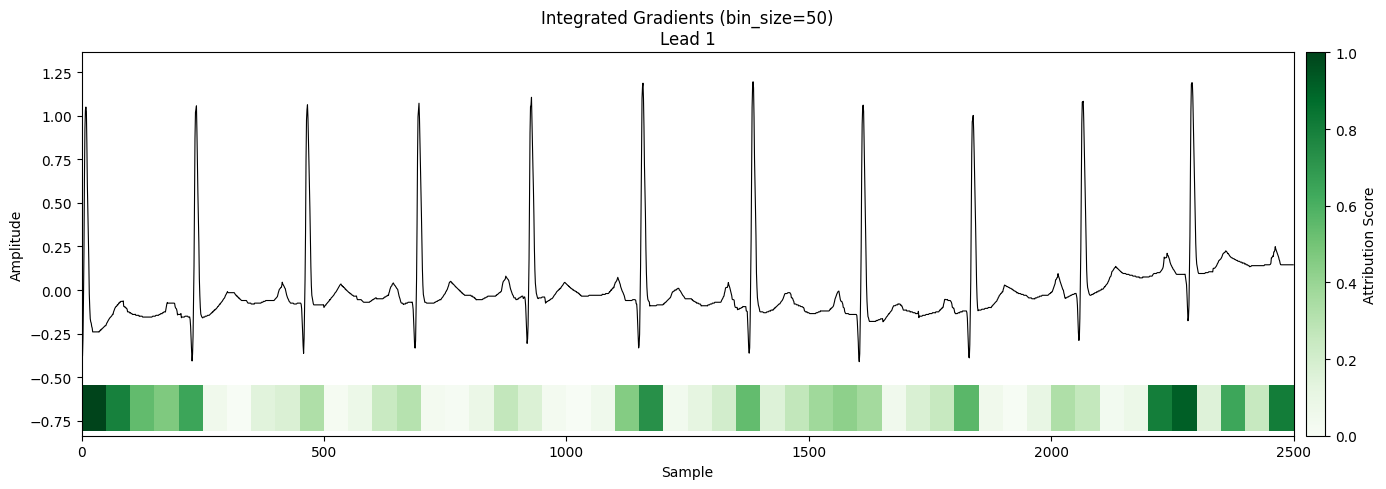

In [8]:
# 1-3. Integrated Gradients
ig_result = saliency.explain(
    ecg_tensor,
    method="integrated_gradients",
    n_steps=50,  # Number of integration steps
    baseline=None,  # If None, uses zero baseline
)
print(f"Integrated Gradients - results shape: {ig_result['results'].shape}")

# Integrated Gradients visualization
plot_attribution(
    ig_result["inputs"][0],
    ig_result["results"][0],
    "Integrated Gradients",
    lead_idx=lead_idx,
    bin_size=bin_size,
    cmap="Greens",
)

## 2. GradCAM Attribution

GradCAM combines activation maps and gradients from convolutional layers to visualize class-specific important regions.

Supported methods:
- `gradcam`: Standard Grad-CAM
- `guided_gradcam`: Combined with Guided Backpropagation
- `gradcam_pp`: Grad-CAM++ (improved version)

In [9]:
# Check model layer names (find Conv layers)
layer_names = wrapped_model.get_layer_names()
conv_layers = [name for name in layer_names if "conv" in name.lower()]
print(
    f"Available conv layers: {conv_layers[-5:] if len(conv_layers) > 5 else conv_layers}"
)  # Last 5 layers

# Use the last conv layer as target (generally the best choice)
target_layer = conv_layers[-1] if conv_layers else layer_names[-2]
print(f"Target layer for GradCAM: {target_layer}")

Available conv layers: ['blk1d.2.1.conv2', 'blk1d.2.2.conv1', 'blk1d.2.2.conv2', 'blk1d.2.3.conv1', 'blk1d.2.3.conv2']
Target layer for GradCAM: blk1d.2.3.conv2


GradCAM - inputs shape: (1, 12, 2500)
GradCAM - results shape: (1, 2500)


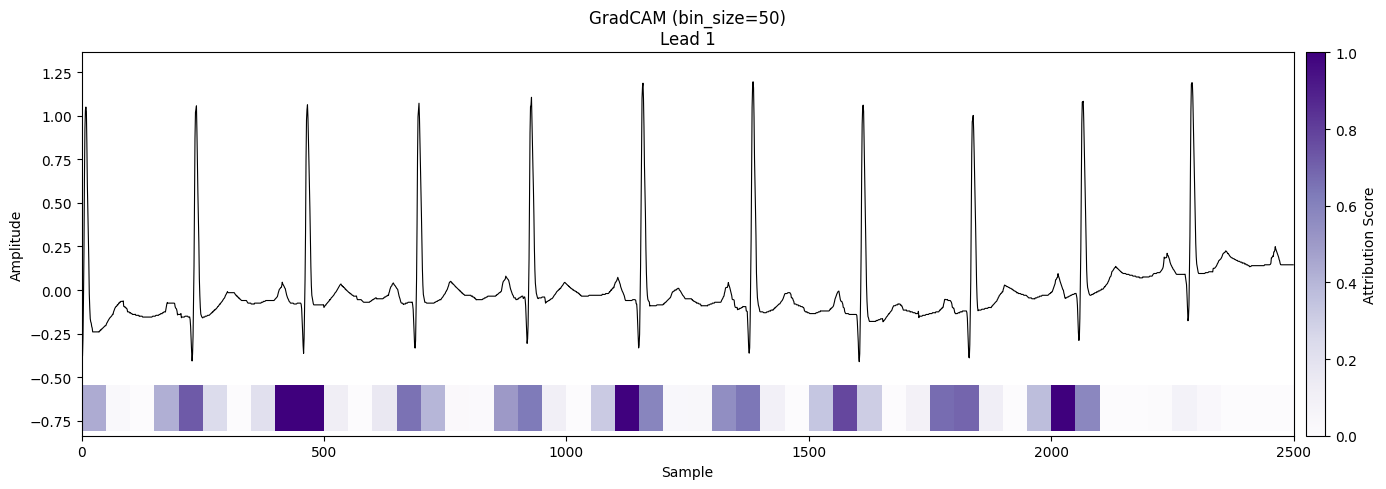

In [10]:
from execg.attribution import GradCAM

# Create GradCAM instance
gradcam = GradCAM(
    model=wrapped_model,
    absolute=True,  # Apply ReLU (remove negatives)
    normalize=True,  # Normalize to 0-1 range
)

# 2-1. Standard GradCAM
gradcam_result = gradcam.explain(
    ecg_tensor, target_layers=target_layer, method="gradcam"
)
print(f"GradCAM - inputs shape: {gradcam_result['inputs'].shape}")
print(f"GradCAM - results shape: {gradcam_result['results'].shape}")

# GradCAM visualization
plot_attribution(
    gradcam_result["inputs"][0],
    gradcam_result["results"][0],
    "GradCAM",
    lead_idx=lead_idx,
    bin_size=bin_size,
    cmap="Purples",
)

/home/jangood1122/anaconda3/envs/solver5/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided GradCAM - results shape: (1, 12, 2500)


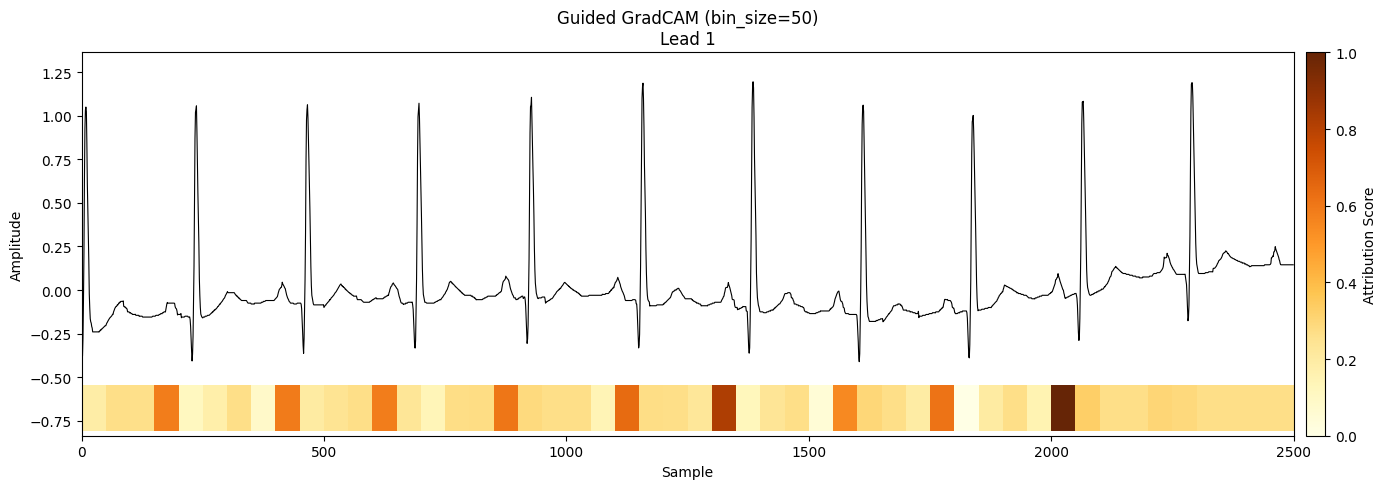

In [11]:
# 2-2. Guided GradCAM
guided_gradcam_result = gradcam.explain(
    ecg_tensor, target_layers=target_layer, method="guided_gradcam"
)
print(f"Guided GradCAM - results shape: {guided_gradcam_result['results'].shape}")

# Guided GradCAM visualization
plot_attribution(
    guided_gradcam_result["inputs"][0],
    guided_gradcam_result["results"][0],
    "Guided GradCAM",
    lead_idx=lead_idx,
    bin_size=bin_size,
    cmap="YlOrBr",
)

GradCAM++ - results shape: (1, 2500)


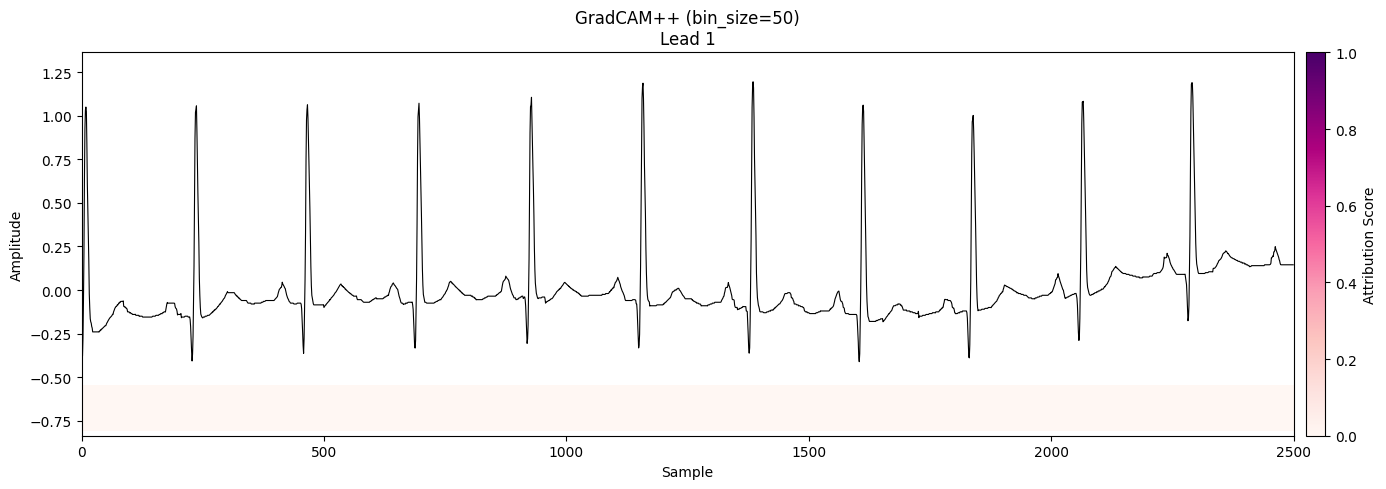

In [12]:
# 2-3. GradCAM++
gradcam_pp_result = gradcam.explain(
    ecg_tensor, target_layers=target_layer, method="gradcam_pp"
)
print(f"GradCAM++ - results shape: {gradcam_pp_result['results'].shape}")

# GradCAM++ visualization
plot_attribution(
    gradcam_pp_result["inputs"][0],
    gradcam_pp_result["results"][0],
    "GradCAM++",
    lead_idx=lead_idx,
    bin_size=bin_size,
    cmap="RdPu",
)

## 3. Comparison of All Methods
Compare multiple attribution methods in a single view.

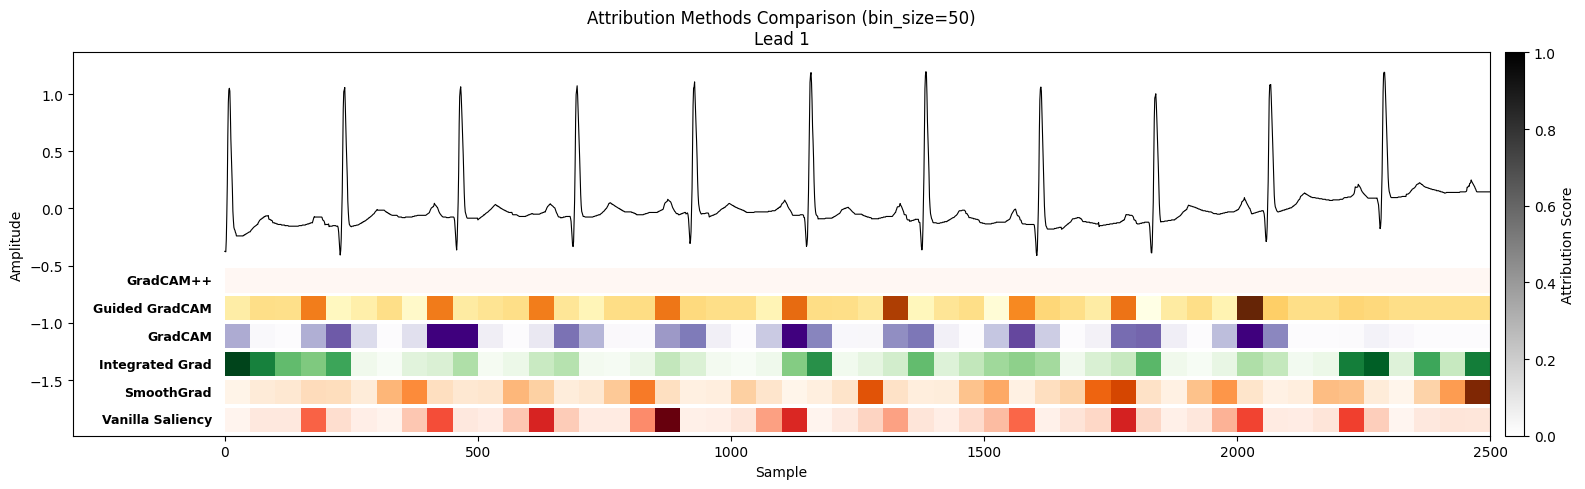

In [17]:
# Compare all methods visualization
methods = {
    "Vanilla Saliency": (vanilla_result["results"][0], "Reds"),
    "SmoothGrad": (smoothgrad_result["results"][0], "Oranges"),
    "Integrated Grad": (ig_result["results"][0], "Greens"),
    "GradCAM": (gradcam_result["results"][0], "Purples"),
    "Guided GradCAM": (guided_gradcam_result["results"][0], "YlOrBr"),
    "GradCAM++": (gradcam_pp_result["results"][0], "RdPu"),
}

fig = plot_attribution_comparison(
    vanilla_result["inputs"][0],
    methods,
    lead_idx=lead_idx,
    bin_size=bin_size,
    figsize=(16, 5),
)

## 4. Attribution for Specific Class

You can compute attribution for a specific class using the `target` parameter.

In [14]:
# Check model prediction
prediction = wrapped_model.predict(ecg_tensor)
print(f"Model prediction shape: {prediction.shape}")
print(f"Predicted class: {prediction.argmax().item()}")
print(f"Class probabilities: {prediction.detach().cpu().numpy()}")

Model prediction shape: torch.Size([1, 2])
Predicted class: 0
Class probabilities: [[9.994766e-01 5.234106e-04]]


In [ ]:
# Compute attribution for a specific class (e.g., class 1)
target_class = 1

# Saliency for specific class
saliency_target = saliency.explain(
    ecg_tensor, target=target_class, method="vanilla_saliency"
)

# GradCAM for specific class
gradcam_target = gradcam.explain(
    ecg_tensor, target=target_class, target_layers=target_layer, method="gradcam"
)

print(f"Attribution for target class {target_class} computed.")